In [1]:
import fitsio
import proplot as pplt
import numpy as np
import glob
import tqdm
import sys

from mattspy.stats import mad

In [52]:
fnames = glob.glob("./results_pam/meas*.fits")

d = []
for fname in tqdm.tqdm(fnames, ncols=79):
    d.append(fitsio.read(fname, ext="data"))
d = np.concatenate(d)

aps = fitsio.read(fname, ext="aps")

sys.stderr.flush()
sys.stdout.flush()
print("# of samples:", d.shape[0])

100%|████████████████████████████████████████████| 3/3 [00:00<00:00,  8.86it/s]


# of samples: 27600


In [53]:
def _resample_stat(x, func, n=500, rng=None):
    if rng is None:
        rng = np.random.RandomState()
        
    vals = []
    for _ in range(n):
        vals.append(func(rng.choice(x, size=len(x), replace=True)))
    return func(x), np.std(vals)


def _resample_stat_two(x, w, func, n=500, rng=None):
    if rng is None:
        rng = np.random.RandomState()
        
    vals = []
    for _ in range(n):
        inds = rng.choice(len(x), size=len(x), replace=True)
        vals.append(func(x[inds], w[inds]))
    return func(x, w), np.std(vals)


def _eff_n(w):
    nrm = np.sum(w)
    nrm2 = np.sum(w*w)
    neff = nrm*nrm/nrm2
    return neff

def _eff_var(x, w):
    nrm = np.sum(w)
    nrm2 = np.sum(w*w)
    neff = nrm*nrm/nrm2
    seff = np.sum((x*w)**2)/nrm/nrm / neff
    return seff/neff

nb = 100
sne = []
frac_kept = []
med_s2n = []
prec = []
rng = np.random
aps_plt = []
eff_n = []
redshifts = []
base_n = []
for i, ap in enumerate(aps):
    msk = (
        (d["flags"][:, i] == 0)
        & (d["s2n"][:, i] > 10)
        & (d["Tratio"][:, i] > 0.5)
    )
    if not np.any(msk):
        continue
    
    base_n.append(np.sum(msk))
    aps_plt.append(ap)
    w = 1.0/(d["e1_err"][msk, i]**2 + mad(d["e1"][msk, i])**2)
    e1 = d["e1"][msk, i]
    sne.append(_resample_stat(e1, mad, n=nb, rng=rng))
    frac_kept.append(
        _resample_stat(msk, lambda x: np.mean(x), n=nb, rng=rng)
        )
    med_s2n.append(
        _resample_stat(d["s2n"][msk, i], lambda x: np.percentile(x, 50), n=nb, rng=rng)
    )
    prec.append(_resample_stat_two(e1, w, _eff_var, n=nb, rng=rng))
    eff_n.append(_resample_stat(w, _eff_n, n=nb, rng=rng))
    redshifts.append(
        _resample_stat(d["redshift"][msk, i], lambda x: np.percentile(x, 50), n=nb, rng=rng)
    )

frac_kept = np.array(frac_kept)
sne = np.array(sne)
med_s2n = np.array(med_s2n)
prec = np.array(prec)
eff_n = np.array(eff_n)
aps_plt = np.array(aps_plt)
redshifts = np.array(redshifts)
base_n = np.array(base_n)

print("eff frac kept", np.max(frac_kept[:, 0]))

eff frac kept 0.1765942028985507


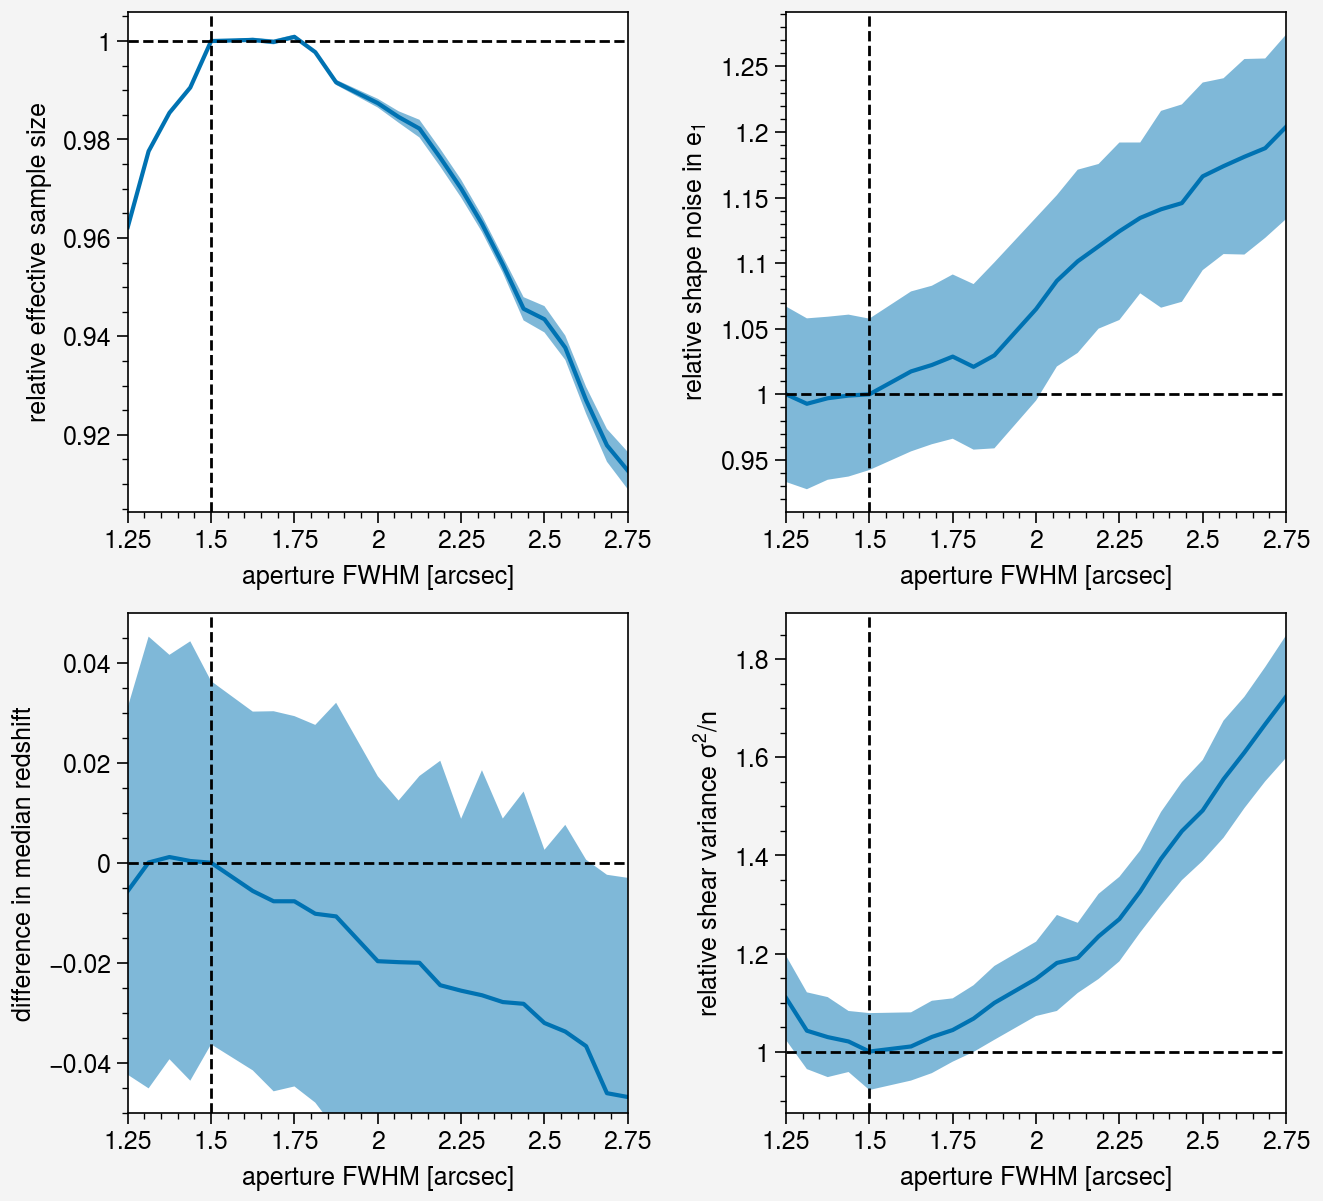

In [54]:
def _errplot(ax, x, ar, hval=1):
    ax.plot(
        x,
        ar[:, 0],
    )
    ax.fill_between(
        x,
        ar[:, 0] - ar[:, 1]*3,
        ar[:, 0] + ar[:, 1]*3,
        alpha=0.5
    )
    ax.grid(False)
    ax.axhline(hval, color='k', linestyle='dashed', lw=1)
    ax.axvline(1.5, color='k', linestyle='dashed', lw=1)
    if hval != 1:
        yy = 0.05
        ax.set_ylim(-yy, yy)


fig, axs = pplt.subplots(nrows=2, ncols=2, share=0)

ind = np.where(np.array(aps_plt) == 1.5)[0][0]

_errplot(axs[0, 0], aps_plt, eff_n/np.max(eff_n[ind, 0]))
axs[0, 0].set_ylabel("relative effective sample size")
axs[0, 0].set_xlabel("aperture FWHM [arcsec]")

_errplot(axs[0, 1], aps_plt, sne / np.min(sne[ind, 0]))
axs[0, 1].set_ylabel("relative shape noise in $e_1$")
axs[0, 1].set_xlabel("aperture FWHM [arcsec]")

if False:
    _errplot(axs[1, 0], aps_plt, med_s2n/np.max(med_s2n[ind, 0]))
    axs[1, 0].set_ylabel("relative median s/n")
    axs[1, 0].set_xlabel("aperture FWHM [arcsec]")
elif True:
    sz = redshifts.copy()
    sz[:, 0] = sz[:, 0] - redshifts[ind, 0]
    _errplot(axs[1, 0], aps_plt, sz, hval=0)
    axs[1, 0].set_ylabel("difference in median redshift")
    axs[1, 0].set_xlabel("aperture FWHM [arcsec]")

else:
    _errplot(axs[1, 0], aps_plt, eff_n/np.max(eff_n[ind, 0]))
    axs[1, 0].set_ylabel("relative effective # of sources")
    axs[1, 0].set_xlabel("aperture FWHM [arcsec]")


_errplot(axs[1, 1], aps_plt, prec/np.min(prec[ind, 0]))
axs[1, 1].set_ylabel(r"relative shear variance $\sigma^{2}/n$")
axs[1, 1].set_xlabel("aperture FWHM [arcsec]")

fig.savefig("optap_am.pdf")

In [56]:
print(redshifts[ind, 0])

1.1662112474441528
